In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import warnings 
warnings.simplefilter('ignore')

import gc
gc.enable()

import datetime

1. 确定数据有效性


2. 分类数据、连续型数据

    2.1 分类数据，value_counts
    
    2.2 跟target做一个merge，pivot_table
    
    2.3 连续型数据，分布可视化，是不是长尾分布，极端数值(3 sigma), 
    
        IQR = 75% precent num - 25% precent num ==> \[25% precent num -1.5 *IQR , 75% + 1.5 * IQR\]


## 定义一个预览类(继承自pd.DataFrame)，用来预览数据
`即 insight.df_preview包中的DfInfo模块`

In [2]:
def _outlier_detector(col: pd.Series):
    """
    判断传入列的每个值是否为空字符串，并获取该值数据类型。

    params:
    col: pandas Series

    returns：

    一个列表，包含该列的空字符串数目、以及一个该列所有值的数据类型的set集合。
    """
    count = 0
    types = set()
    for j in col:
        if isinstance(j, str) and j.strip() == "":
            count += 1
        types.add(type(j))

    return [count, types]


class DataFrameInfo(pd.DataFrame):
    """
    定义一个类，继承pandas.DataFrame，方便查看数据和其他EDA定制化数据查看需求。
    """

    def preview(self) -> pd.DataFrame:
        """
        用于数据预览，查看数据集的各种数据属性。

        returns:

        total: 数量,
        na: 空值,
        naPercent: 空值所占该列比例,
        dtype: 该列的数据类型(dtype),
        max: 该列最大值,
        75%: 75%分位数,
        median: 中位数,
        25%: 25%分位数,
        min:该列最小值,
        mean: 均值,
        mode: 众数,
        variation: 异众比率,
        nunique: 唯一值的个数,
        std: 标准差,
        skew: 偏度系数,
        kurt: 峰度系数,
        samples: 随机返回该列两个值
        """

        col = self.columns
        ind_len = self.shape[0]

        df = pd.DataFrame(columns=['total', 'na', 'naPercent', 'type', 'max', '75%', 'median',
                                   '25%', 'min', 'mean', 'mode', 'variation', 'nunique','std', 'skew', 'kurt', 'samples'])

        pointer = 0
        for i in col:
            samples = ' || '.join([str(self[i][j]) for j in np.random.randint(ind_len, size=2)])
            if sum(self.iloc[:, pointer].apply(lambda s: isinstance(s, (float, int)))) == \
                    len(self.iloc[:, pointer]):
                value = {'total': ind_len,
                         'na': self[i].isnull().sum(),
                         'naPercent': self[i].isnull().sum() / ind_len,
                         'type': self[i].dtype,
                         'max': self[i].max(),
                         '75%': self[i].quantile(0.75),
                         'median': self[i].median(),
                         '25%': self[i].quantile(0.25),
                         'min': self[i].min(),
                         'mean': self[i].mean(),
                         'mode': self[i].value_counts(ascending=False).index[0],
                         'variation': self[i].value_counts(ascending=False).values[1:].sum() / ind_len,
                         'nunique':self[i].nunique(),
                         'std': self[i].std(),
                         'skew': self[i].skew(),
                         'kurt': self[i].kurt(),
                         'samples': samples
                         }
            else:
                value = {'total': ind_len,
                         'na': self[i].isnull().sum(),
                         'naPercent': self[i].isnull().sum() / ind_len,
                         'type': self[i].dtype,
                         'max': np.nan,
                         '75%': np.nan,
                         'median': np.nan,
                         '25%': np.nan,
                         'min': np.nan,
                         'mean': np.nan,
                         'mode': self[i].value_counts(ascending=False).index[0],
                         'variation': self[i].value_counts(ascending=False).values[1:].sum() / ind_len,
                         'nunique': self[i].nunique(),
                         'std': np.nan,
                         'skew': np.nan,
                         'kurt': np.nan,
                         'samples': samples
                         }
            df.loc[i] = pd.Series(value, name=i)
            pointer += 1

        return df

    def abnormal(self) -> pd.DataFrame:
        """
        查看数据集的异常值情况。

        returns：

        na: 该列的空值数目,
        nullStrings: 该列空字符串数目,
        valueTypes：该列所有数值的数据类型set集合
        variation: 返回该列异众比率
        """

        df = pd.DataFrame(columns=['na', 'nullStrings', 'valueTypes'])

        for i in self.columns:
            df.loc[i] = pd.Series({
                'na': sum(self[i].isna()),
                'nullStrings': _outlier_detector(self[i])[0],
                'valueTypes': _outlier_detector(self[i])[1],
            }, name=i)

        return df
    
    
dfi = DataFrameInfo

In [3]:
# 读入数据，并打印数据占用内存
train_df = pd.read_csv("train.csv")
print(f"train_df:{round(train_df.memory_usage().sum() / 1024 **2, 2)} MB")
test_df = pd.read_csv("testA.csv")
print(f"test_df:{round(test_df.memory_usage().sum() / 1024 **2, 2)} MB")

train_df:286.87 MB
test_df:73.24 MB


In [45]:
train_df.preview()

,total,na,naPercent,type,max,75%,median,25%,min,mean,mode,variation,nunique,std,skew,kurt,samples
id,800000,0,0.000000,int64,799999,599999.25,399999.500,199999.75,0,399999.500000,2047,0.999999,800000,230940.252015,-2.234765e-15,-1.200000,115846 || 352992
loanAmnt,800000,0,0.000000,float64,40000,20000.00,12000.000,8000.00,500,14416.818875,10000,0.926165,1540,8716.086178,7.826221e-01,-0.083396,26000.0 || 9000.0
term,800000,0,0.000000,int64,5,3.00,3.000,3.00,3,3.482745,3,0.241372,2,0.855832,1.208780e+00,-0.538852,3 || 3
interestRate,800000,0,0.000000,float64,30.99,15.99,12.740,9.75,5.31,13.238391,10.99,0.971814,641,4.765757,7.123646e-01,0.502096,13.49 || 21.49
installment,800000,0,0.000000,float64,1715.42,580.71,375.135,248.45,15.69,437.947723,327.34,0.997696,72360,261.460393,1.006328e+00,0.746771,945.5 || 217.01
grade,800000,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,B,0.707888,7,NaN,NaN,NaN,B || B
subGrade,800000,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,C1,0.936546,35,NaN,NaN,NaN,C2 || C4
employmentTitle,800000,1,0.000001,float64,378351,117663.50,7755.000,427.00,0,72005.351714,54,0.936063,248683,106585.640204,1.379124e+00,0.549221,290951.0 || 2318.0
employmentLength,800000,46799,0.058499,object,NaN,NaN,NaN,NaN,NaN,NaN,10+ years,0.613060,11,NaN,NaN,NaN,10+ years || < 1 year
homeOwnership,800000,0,0.000000,int64,5,1.00,1.000,0.00,0,0.614213,0,0.505335,6,0.675749,6.759417e-01,-0.470440,1 || 1


In [4]:
sample = train_df.sample(5)
print(f"{'==>'*20} \n Top 30% columns: \n {sample.iloc[:, :int(np.ceil(len(train_df.columns)/3))]} \n {'<=='*20} \n") # 打印前3分之一列
print(f"{'==>'*20} \n 30%-60% columns: \n   {sample.iloc[:, int(np.ceil(len(train_df.columns)/3)): int(np.ceil(len(train_df.columns)/3)) * 2 ]} \n {'<=='*20} \n")
print(f"{'==>'*20} \n Tail 30% columns: \n  {sample.iloc[:, int(np.ceil(len(train_df.columns)/3)) * 2: ]} \n {'<=='*20} \n")

==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==> 
 Top 30% columns: 
             id  loanAmnt  term  interestRate  installment grade subGrade  \
192611  192611   10000.0     5         15.61       241.12     D       D1   
631561  631561   14400.0     3          7.39       447.21     A       A4   
2003      2003    6250.0     3         19.52       230.75     E       E2   
403987  403987   20000.0     3          6.24       610.62     A       A2   
777535  777535   12000.0     3         25.49       480.24     E       E4   

        employmentTitle employmentLength  homeOwnership  annualIncome  \
192611             62.0          6 years              1       61000.0   
631561             62.0          5 years              2       82000.0   
2003               54.0              NaN              0       23000.0   
403987          68964.0           1 year              1      140000.0   
777535            347.0          3 years              0       70000.0   

        verificationSt

In [5]:
sample = test_df.sample(5)
print(f"{'==>'*20} \n Top 30% columns: \n  {sample.iloc[:, :int(np.ceil(len(test_df.columns)/3))]} \n {'<=='*20} \n") # 打印前3分之一列
print(f"{'==>'*20} \n 30%-60% columns: \n  {sample.iloc[:, int(np.ceil(len(test_df.columns)/3)): int(np.ceil(len(test_df.columns)/3)) * 2 ]} \n {'<=='*20} \n")
print(f"{'==>'*20} \n Tail 30% columns: \n  {sample.iloc[:, int(np.ceil(len(test_df.columns)/3)) * 2: ]} \n {'<=='*20} \n")

==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==> 
 Top 30% columns: 
              id  loanAmnt  term  interestRate  installment grade subGrade  \
102660  902660   16000.0     3          5.32       481.84     A       A1   
87518   887518   15000.0     3         11.22       492.65     B       B5   
169823  969823   16000.0     3          7.49       497.63     A       A4   
23441   823441    5500.0     3         16.29       194.16     D       D1   
152430  952430    7000.0     3          7.91       219.07     A       A5   

        employmentTitle employmentLength  homeOwnership  annualIncome  \
102660          17411.0          2 years              1       90000.0   
87518             851.0          3 years              1      140000.0   
169823           2332.0          2 years              0       60000.0   
23441            1342.0          3 years              1       50000.0   
152430         164928.0          2 years              0       60000.0   

        verificationS

In [6]:
print(train_df.shape)
print(test_df.shape)

(800000, 47)
(200000, 48)


In [7]:
# 找到target 列
for i in train_df.columns.to_list():
    if i not in test_df.columns.to_list():
        print(i)

isDefault


In [8]:
# 查看为什么test_df的列数比train_df的多
for i in test_df.columns.to_list():
    if i not in train_df.columns.to_list():
        print(i)

n2.2
n2.3


In [9]:
# 查看train和test数据集中有哪些列是不一样的
set_columns = set()
for i in train_df.columns:
    for j in test_df.columns:
        if i not in test_df.columns:
            set_columns.add(str(i)+'_train')
        elif j not in train_df.columns:
            set_columns.add(str(j)+'_test')
print(set_columns)

{'isDefault_train', 'n2.2_test', 'n2.3_test'}


In [10]:
# 以下几行重复，需要进行删除
print(np.sum(train_df['n2'] - train_df['n2.1']))
print(np.sum(test_df['n2'] - test_df['n2.1']))
print(np.sum(test_df['n2'] - test_df['n2.2']))
print(np.sum(test_df['n2'] - test_df['n2.3']))

0.0
0.0
0.0
0.0


训练集和测试集的列数不一致，其中training set中的isDefault是target列，而test set中的n2.2, n2.3是特征列，没有出现在training set中。

In [11]:
train_df = dfi(train_df)
pv_train = train_df.preview()
test_df = dfi(test_df)
pv_test = test_df.preview()

## 数据分布探索

In [12]:
def plot_na(df:pd.DataFrame, percentage:bool = True):
    
    sns.set()
    if percentage is True:
        target_col = 'naPercent'
    else:
        target_col = 'na'

    _ = df.query('na > 0')[target_col].sort_values(ascending=True)
    _.plot(kind='barh', figsize=(12, 8), title=f'Plot {target_col}')

    for a, b in enumerate(_.values):
        plt.text(b, a-0.2, str(b))
    plt.show()

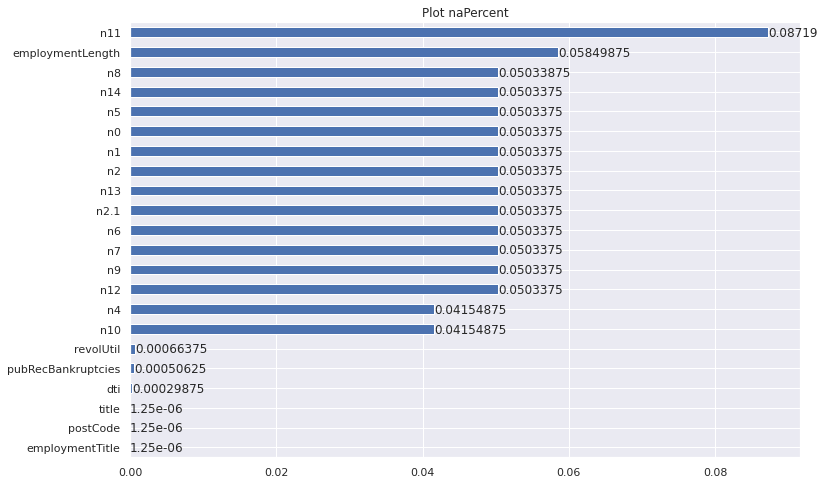

In [13]:
# 训练集各列空值所占比例
plot_na(pv_train)

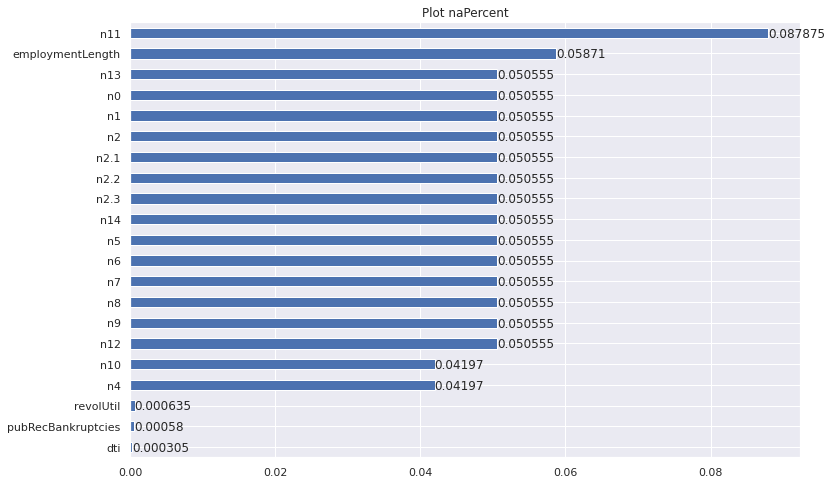

In [14]:
plot_na(pv_test)

In [46]:
pv_train

,total,na,naPercent,type,max,75%,median,25%,min,mean,mode,variation,nunique,std,skew,kurt,samples
id,800000,0,0.000000,int64,799999,599999.25,399999.500,199999.75,0,399999.500000,2047,0.999999,800000,230940.252015,-2.234765e-15,-1.200000,70417 || 728275
loanAmnt,800000,0,0.000000,float64,40000,20000.00,12000.000,8000.00,500,14416.818875,10000,0.926165,1540,8716.086178,7.826221e-01,-0.083396,8500.0 || 25000.0
term,800000,0,0.000000,int64,5,3.00,3.000,3.00,3,3.482745,3,0.241372,2,0.855832,1.208780e+00,-0.538852,3 || 3
interestRate,800000,0,0.000000,float64,30.99,15.99,12.740,9.75,5.31,13.238391,10.99,0.971814,641,4.765757,7.123646e-01,0.502096,10.42 || 18.99
installment,800000,0,0.000000,float64,1715.42,580.71,375.135,248.45,15.69,437.947723,327.34,0.997696,72360,261.460393,1.006328e+00,0.746771,137.32 || 266.4
grade,800000,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,B,0.707888,7,NaN,NaN,NaN,B || D
subGrade,800000,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,C1,0.936546,35,NaN,NaN,NaN,B5 || C2
employmentTitle,800000,1,0.000001,float64,378351,117663.50,7755.000,427.00,0,72005.351714,54,0.936063,248683,106585.640204,1.379124e+00,0.549221,249728.0 || 151.0
employmentLength,800000,46799,0.058499,object,NaN,NaN,NaN,NaN,NaN,NaN,10+ years,0.613060,11,NaN,NaN,NaN,2 years || nan
homeOwnership,800000,0,0.000000,int64,5,1.00,1.000,0.00,0,0.614213,0,0.505335,6,0.675749,6.759417e-01,-0.470440,1 || 0


In [15]:
# 查看训练集和测试集各列的唯一值情况
print(pv_train[['variation', 'nunique']].sort_values(by='variation', ascending=True)[:15])
print('-'*50)
print(pv_test[['variation', 'nunique']].sort_values(by='variation', ascending=True)[:15])

                    variation nunique
policyCode           0.000000       1
n11                  0.000708       5
n12                  0.003019       5
applicationType      0.019267       2
n13                  0.054499      28
pubRecBankruptcies   0.124399      11
pubRec               0.169044      32
delinquency_2years   0.192856      30
isDefault            0.199513       2
n0                   0.225379      39
term                 0.241372       2
initialListStatus    0.416953       2
purpose              0.419880      14
homeOwnership        0.505335       6
title                0.508331   39644
--------------------------------------------------
                    variation nunique
policyCode           0.000000       1
n11                  0.000720       4
n12                  0.003210       4
applicationType      0.019465       2
n13                  0.054445      22
pubRecBankruptcies   0.125330      10
pubRec               0.169535      22
delinquency_2years   0.192655      23

In [16]:
# 查看数据类型
print(pv_train['type'][pv_train['type'] == 'object'])
print('-'*50)
print(pv_train['type'][pv_train['type'] == 'float64'])
print('-'*50)
print(pv_train['type'][pv_train['type'] == 'int64'])
print('-'*50)
print(pv_train['type'][(pv_train['type'] != 'object') & (pv_train['type'] != 'float64') 
                       & (pv_train['type'] != 'int64')])

grade                object
subGrade             object
employmentLength     object
issueDate            object
earliesCreditLine    object
Name: type, dtype: object
--------------------------------------------------
loanAmnt              float64
interestRate          float64
installment           float64
employmentTitle       float64
annualIncome          float64
postCode              float64
dti                   float64
delinquency_2years    float64
ficoRangeLow          float64
ficoRangeHigh         float64
openAcc               float64
pubRec                float64
pubRecBankruptcies    float64
revolBal              float64
revolUtil             float64
totalAcc              float64
title                 float64
policyCode            float64
n0                    float64
n1                    float64
n2                    float64
n2.1                  float64
n4                    float64
n5                    float64
n6                    float64
n7                    float64
n8 

In [47]:
train_df.info()

<class '__main__.DataFrameInfo'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 48 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  800000 non-null  int64         
 1   loanAmnt            800000 non-null  float64       
 2   term                800000 non-null  int64         
 3   interestRate        800000 non-null  float64       
 4   installment         800000 non-null  float64       
 5   grade               800000 non-null  object        
 6   subGrade            800000 non-null  object        
 7   employmentTitle     799999 non-null  float64       
 8   employmentLength    753201 non-null  object        
 9   homeOwnership       800000 non-null  int64         
 10  annualIncome        800000 non-null  float64       
 11  verificationStatus  800000 non-null  int64         
 12  issueDate           800000 non-null  datetime64[ns]
 13  isDefault           800000 non-nul

在训练集和测试集中，policyCode这一列都只有唯一值，可以删除

In [17]:
useless_col = ['policyCode']

## 对数值型和object型数据分开分析

In [18]:
# 类别型数据
category_fea = pv_train['type'][pv_train['type'] == 'object'].index.to_list()
# 数值型数据
numeric_fea = pv_train['type'][pv_train['type'] != 'object'].index.to_list()

In [19]:
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

### 对数值型变量划分出离散型变量和连续型变量

In [20]:
# 离散型随机变量，这里定义特征取值数目小于等于10为离散型随机变量
numerical_noserial_fea = pv_train.loc[numeric_fea,:].loc[pv_train['nunique']<= 10].index.to_list()

In [21]:
numerical_noserial_fea

['term',
 'homeOwnership',
 'verificationStatus',
 'isDefault',
 'initialListStatus',
 'applicationType',
 'policyCode',
 'n11',
 'n12']

In [22]:
# 连续型随机变量
numerical_serial_fea = [i for i in pv_train.loc[numeric_fea,:].index if i not in numerical_noserial_fea]

In [23]:
# 对可疑的特征，分析是不是连续型数据
# postCode, regionCode, title, purpose
# 如果一个特征均为整数，并且从常理上判断是分类的，则有可能为分类的，或者是label encoder转换过的
train_df[['postCode', 'regionCode', 'title', 'purpose']]

,postCode,regionCode,title,purpose
0,137.0,32,1.0,1
1,156.0,18,1723.0,0
2,337.0,14,0.0,0
3,148.0,11,4.0,4
4,301.0,21,11.0,10
...,...,...,...,...
799995,242.0,8,0.0,0
799996,563.0,10,33369.0,4
799997,47.0,17,0.0,0
799998,34.0,18,4.0,4


### 数值类别型变量分析

In [48]:
for i in numerical_noserial_fea:
    print(f"{i}:")
    print(train_df[i].value_counts(normalize=True))
    print("-"*50)

term:
3    0.758628
5    0.241372
Name: term, dtype: float64
--------------------------------------------------
homeOwnership:
0    0.494665
1    0.397075
2    0.107886
3    0.000231
5    0.000101
4    0.000041
Name: homeOwnership, dtype: float64
--------------------------------------------------
verificationStatus:
1    0.387263
2    0.311210
0    0.301528
Name: verificationStatus, dtype: float64
--------------------------------------------------
isDefault:
0    0.800488
1    0.199513
Name: isDefault, dtype: float64
--------------------------------------------------
initialListStatus:
0    0.583048
1    0.416953
Name: initialListStatus, dtype: float64
--------------------------------------------------
applicationType:
0    0.980733
1    0.019267
Name: applicationType, dtype: float64
--------------------------------------------------
policyCode:
1.0    1.0
Name: policyCode, dtype: float64
--------------------------------------------------
n11:
0.0    0.999225
1.0    0.000739
2.0    0.0

### 数值型连续型随机变量分析

In [26]:
# 判断是否有异常值
dfi(train_df[numerical_serial_fea]).abnormal().sort_values(by='na', ascending=False)

,na,nullStrings,valueTypes
n8,40271,0,{<class 'float'>}
n14,40270,0,{<class 'float'>}
n7,40270,0,{<class 'float'>}
n1,40270,0,{<class 'float'>}
n2,40270,0,{<class 'float'>}
n2.1,40270,0,{<class 'float'>}
n5,40270,0,{<class 'float'>}
n6,40270,0,{<class 'float'>}
n0,40270,0,{<class 'float'>}
n9,40270,0,{<class 'float'>}


In [49]:
train_df.columns   # flatten

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n2.1', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'issueDateDT'],
      dtype='object')

In [27]:
f = pd.melt(train_df, value_vars=numerical_serial_fea)
f  # memoryError

,variable,value
0,id,0.0
1,id,1.0
2,id,2.0
3,id,3.0
4,id,4.0
...,...,...
26399995,n14,3.0
26399996,n14,0.0
26399997,n14,4.0
26399998,n14,5.0


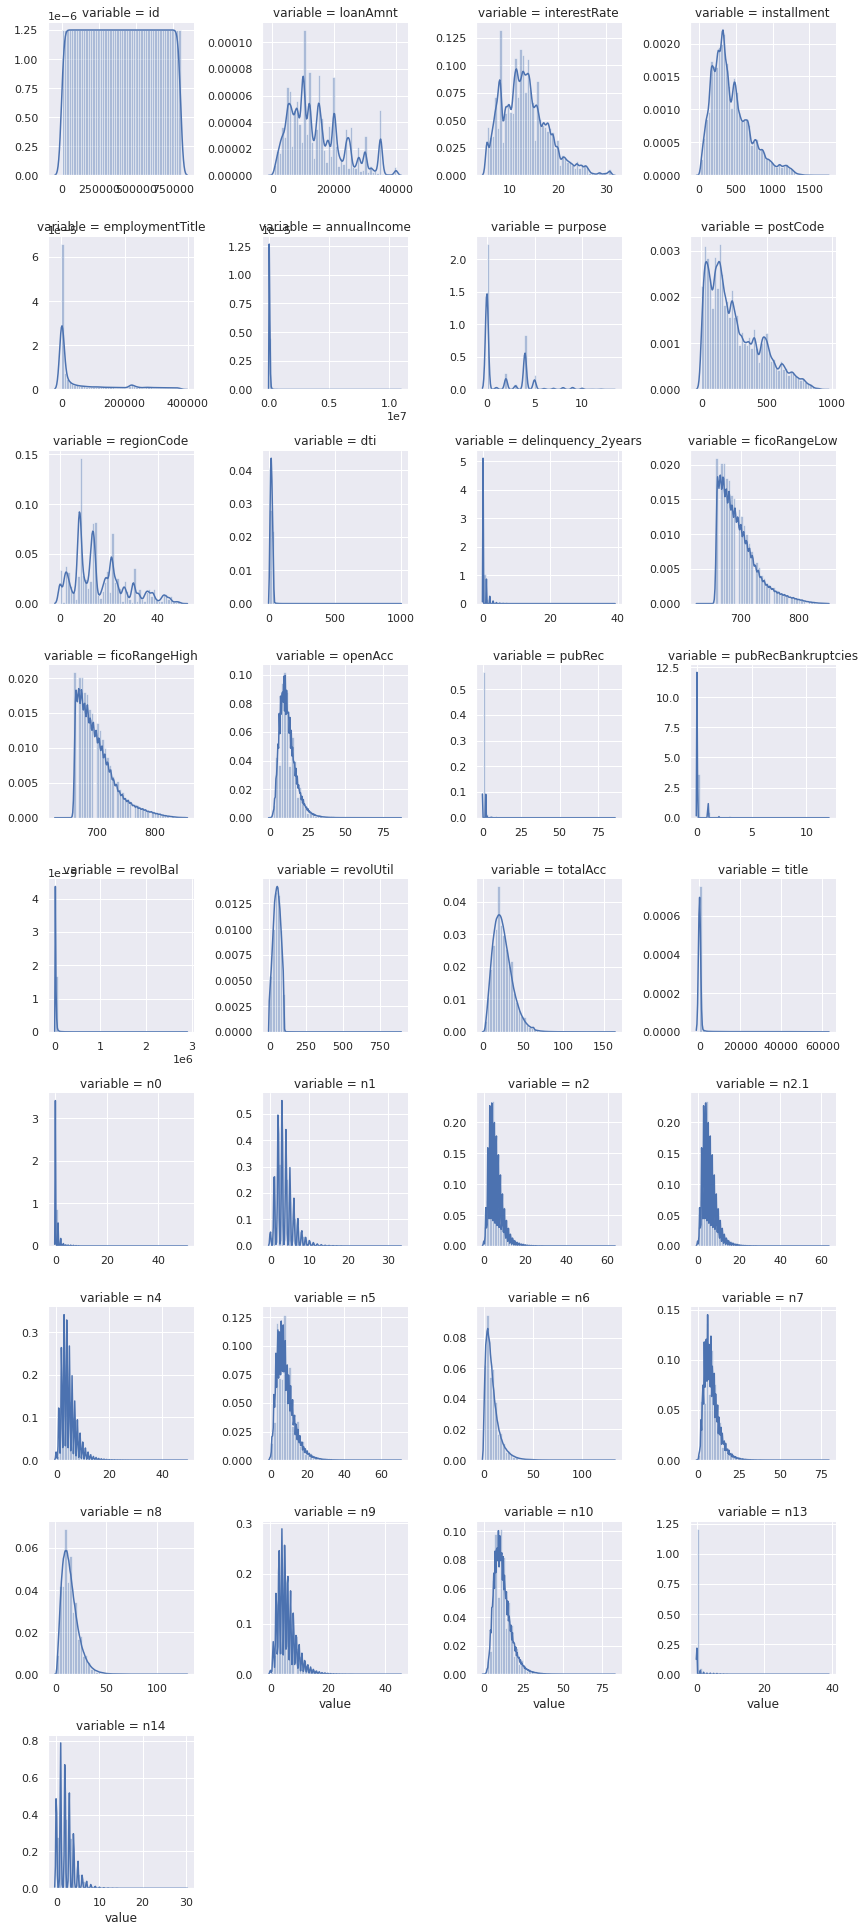

In [28]:
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

### 非数值类别型变量分析

In [29]:
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [30]:
for i in category_fea:
    print(f"{i}:")
    print(train_df[i].value_counts())
    print("-"*50)

grade:
B    233690
C    227118
A    139661
D    119453
E     55661
F     19053
G      5364
Name: grade, dtype: int64
--------------------------------------------------
subGrade:
C1    50763
B4    49516
B5    48965
B3    48600
C2    47068
C3    44751
C4    44272
B2    44227
B1    42382
C5    40264
A5    38045
A4    30928
D1    30538
D2    26528
A1    25909
D3    23410
A3    22655
A2    22124
D4    21139
D5    17838
E1    14064
E2    12746
E3    10925
E4     9273
E5     8653
F1     5925
F2     4340
F3     3577
F4     2859
F5     2352
G1     1759
G2     1231
G3      978
G4      751
G5      645
Name: subGrade, dtype: int64
--------------------------------------------------
employmentLength:
10+ years    262753
2 years       72358
< 1 year      64237
3 years       64152
1 year        52489
5 years       50102
4 years       47985
6 years       37254
8 years       36192
7 years       35407
9 years       30272
Name: employmentLength, dtype: int64
-----------------------------------------------

## 查看y值分布

In [31]:
print(len(train_df['isDefault'][train_df['isDefault'] == 1]))
print(len(train_df['isDefault'][train_df['isDefault'] == 0]))

159610
640390


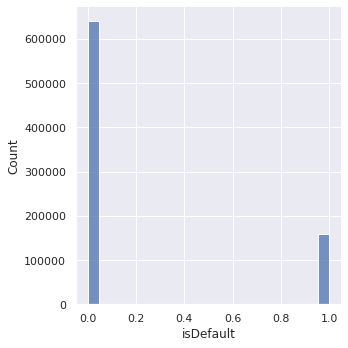

In [32]:
sns.set()
sns.displot(data=train_df['isDefault'])
plt.show()

## 根据y值查看变量分布

In [33]:
train_loan_fr = train_df.loc[train_df['isDefault'] == 1]  # 欺诈
train_loan_nofr = train_df.loc[train_df['isDefault'] == 0] # 非欺诈

就业年限和贷款等级对贷款风险的影响

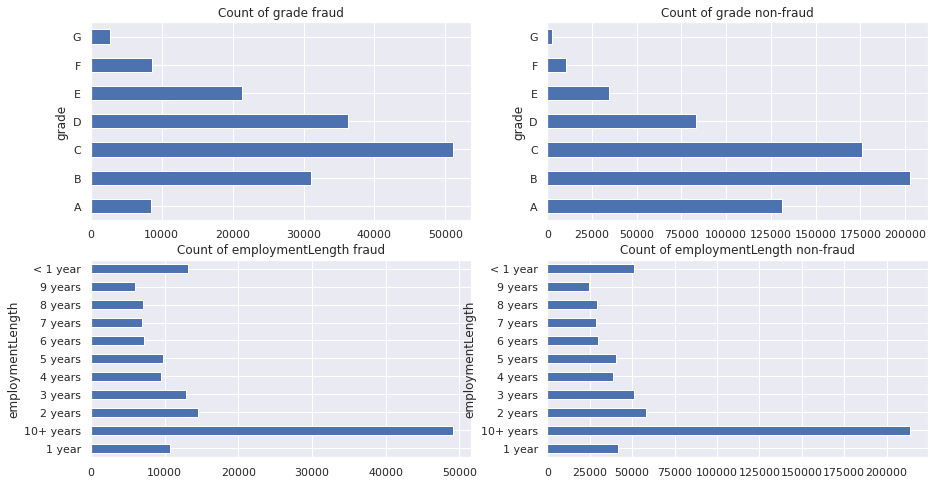

In [34]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_loan_fr.groupby('grade')['grade'].count().\
                        plot(kind='barh', ax=ax1, title="Count of grade fraud")
train_loan_nofr.groupby('grade')['grade'].count().\
                        plot(kind='barh', ax=ax2, title='Count of grade non-fraud')
train_loan_fr.groupby('employmentLength')['employmentLength'].count().\
                        plot(kind='barh', ax=ax3, title='Count of employmentLength fraud')
train_loan_nofr.groupby('employmentLength')['employmentLength'].count().\
                        plot(kind='barh', ax=ax4, title='Count of employmentLength non-fraud')
plt.show()

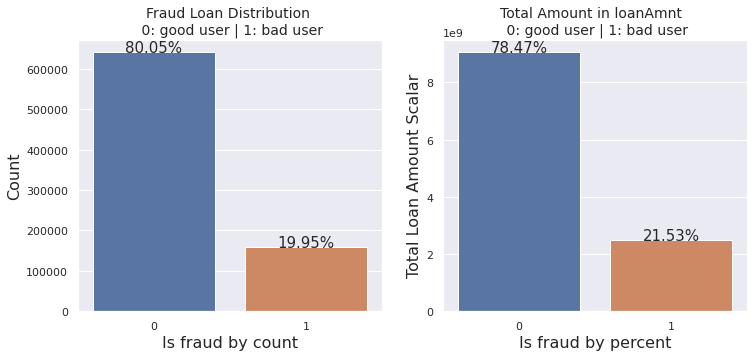

In [35]:
total = len(train_df)
total_amt = train_df.groupby(['isDefault'])['loanAmnt'].sum().sum()
plt.figure(figsize=(12,5))
plt.subplot(121)##1代表行，2代表列，所以一共有2个图，1代表此时绘制第一个图。
plot_tr = sns.countplot(x='isDefault',data=train_df)#data_train‘isDefault’这个特征每种类别的数量**
plot_tr.set_title("Fraud Loan Distribution \n 0: good user | 1: bad user", fontsize=14)
plot_tr.set_xlabel("Is fraud by count", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
    
percent_amt = (train_df.groupby(['isDefault'])['loanAmnt'].sum())
percent_amt = percent_amt.reset_index()
plt.subplot(122)
plot_tr_2 = sns.barplot(x='isDefault', y='loanAmnt',  dodge=True, data=percent_amt)
plot_tr_2.set_title("Total Amount in loanAmnt  \n 0: good user | 1: bad user", fontsize=14)
plot_tr_2.set_xlabel("Is fraud by percent", fontsize=16)
plot_tr_2.set_ylabel('Total Loan Amount Scalar', fontsize=16)
for p in plot_tr_2.patches:
    height = p.get_height()
    plot_tr_2.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15)     

## 相关性分析

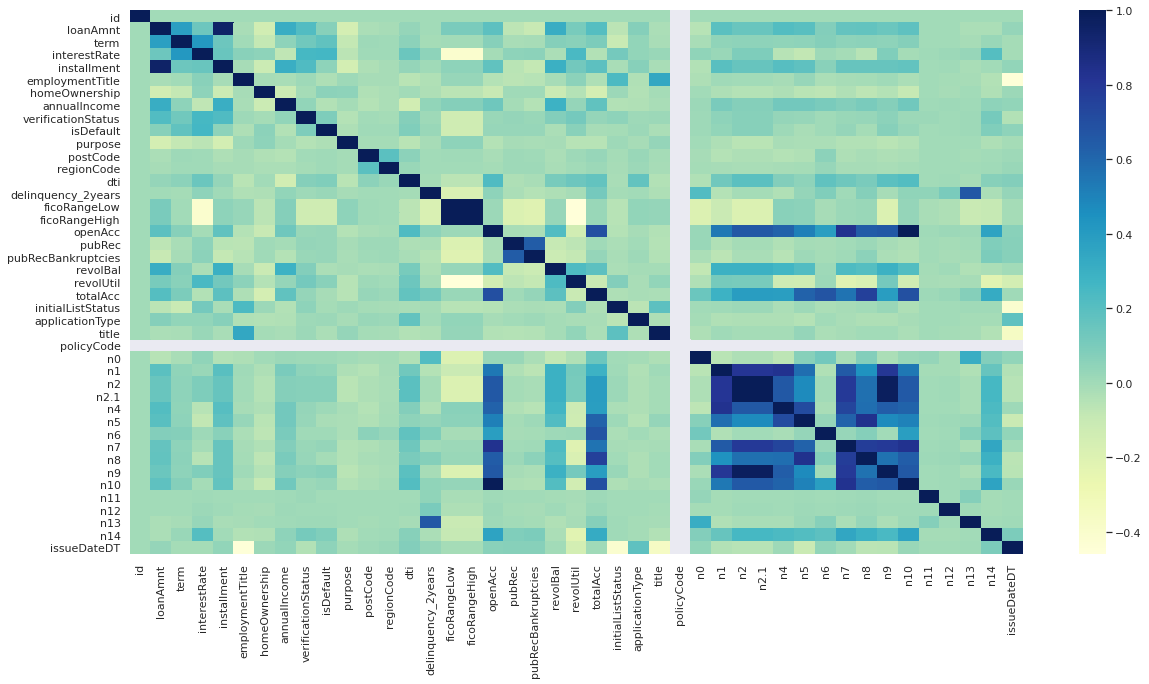

In [55]:
corr = train_df.corr()   # pearson, kendall, spearman
ax = plt.figure(figsize=(20, 10))
ax = sns.heatmap(corr, cmap="YlGnBu")

## 时间格式数据处理及查看

In [36]:
train_df['issueDate'].min()

'2007-06-01'

In [37]:
#转化为时间格式
train_df['issueDate'] = pd.to_datetime(train_df['issueDate'], format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
train_df['issueDateDT'] = train_df['issueDate'].apply(lambda s: s-startdate).dt.days

In [38]:
#转化成时间格式
test_df['issueDate'] = pd.to_datetime(test_df['issueDate'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
test_df['issueDateDT'] = test_df['issueDate'].apply(lambda x: x-startdate).dt.days

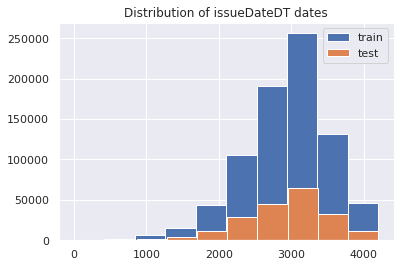

In [39]:
plt.hist(train_df['issueDateDT'], label='train');
plt.hist(test_df['issueDateDT'], label='test');
plt.legend();
plt.title('Distribution of issueDateDT dates');
# train 和 test issueDateDT 日期有重叠 所以使用基于时间的分割进行验证是不明智的,容易出现时间穿越问题

## 透视表查看数据

查看不同贷款等级的用户在不同贷款日期的贷款金额

In [40]:
#透视图 索引可以有多个，“columns（列）”是可选的，聚合函数aggfunc最后是被应用到了变量“values”中你所列举的项目上。
pivot = pd.pivot_table(train_df, index=['grade'], columns=['issueDateDT'], values=['loanAmnt'], aggfunc=np.sum)

In [41]:
pivot

loanAmnt                                                         \
issueDateDT     0        30       61       92       122      153       183    
grade                                                                         
A                NaN  53650.0  42000.0  19500.0  34425.0  63950.0   43500.0   
B                NaN  13000.0  24000.0  32125.0   7025.0  95750.0  164300.0   
C                NaN  68750.0   8175.0  10000.0  61800.0  52550.0  175375.0   
D                NaN      NaN   5500.0   2850.0  28625.0      NaN  167975.0   
E             7500.0      NaN  10000.0      NaN  17975.0   1500.0   94375.0   
F                NaN      NaN  31250.0   2125.0      NaN      NaN       NaN   
G                NaN      NaN      NaN      NaN      NaN      NaN       NaN   

                                           ...                          \
issueDateDT      214       245       274   ...        3926        3957   
grade                                      ...                           
A            168825.0   85600.0  101825.0  ...  13093850.0  11757325.0   
B            303175.0  434425.0  538450.0  ...  16863100.0  17275175.0   
C            151100.0  243725.0  393150.0  ...  17502375.0  17471500.0   
D            171325.0  192900.0  269325.0  ...  11403075.0  10964150.0   
E            116450.0   42000.0  139775.0  ...   3983050.0   3410125.0   
F             49000.0   27000.0   43000.0  ...   1074175.0    868925.0   
G             24625.0       NaN       NaN  ...     56100.0    243275.0   

                                                                       \
issueDateDT        3987        4018        4048       4079       4110   
grade                                                                   
A            11945975.0   9144000.0   7977650.0  6888900.0  5109800.0   
B            16217500.0  11431350.0   8967750.0  7572725.0  4884600.0   
C            16111225.0  11973675.0  10184450.0  7765000.0  5354450.0   
D            10747675.0   7082050.0   7189625.0  5195700.0  3455175.0   
E             3107150.0   2341825.0   2225675.0  1643675.0  1091025.0   
F              761675.0    685325.0    665750.0   685200.0   316700.0   
G              224825.0     64050.0    198575.0   245825.0    53125.0   

                                              
issueDateDT       4140       4171       4201  
grade                                         
A            3919275.0  2694025.0  2245625.0  
B            4329400.0  3922575.0  3257100.0  
C            4552600.0  2870050.0  2246250.0  
D            3038500.0  2452375.0  1771750.0  
E            1131625.0   883950.0   802425.0  
F             315075.0    72300.0        NaN  
G              23750.0    25100.0     1000.0  

[7 rows x 139 columns]

查看不同贷款等级、不同就业年限用户的平均贷款金额

In [42]:
pivot2 = pd.pivot_table(train_df, index=['grade'], columns=['employmentLength'], 
               values=['loanAmnt'], aggfunc=np.mean).apply(lambda s: round(s, 2))
pivot2

loanAmnt                                                    \
employmentLength    1 year 10+ years   2 years   3 years   4 years   5 years   
grade                                                                          
A                 13335.90  14639.78  13388.46  13486.87  13553.71  13497.00   
B                 12486.31  14191.58  12655.77  12852.25  12997.18  13048.17   
C                 13093.05  15527.29  13383.55  13587.21  13731.96  13860.52   
D                 14204.81  16918.67  14418.18  14476.06  14837.77  14834.85   
E                 16304.01  19339.69  16762.51  16840.06  17080.68  17478.84   
F                 17570.02  20787.57  17880.98  18417.19  18881.52  19196.17   
G                 18475.92  22099.39  20240.04  19995.32  19587.09  20858.56   

                                                                    
employmentLength   6 years   7 years   8 years   9 years  < 1 year  
grade                                                               
A                 13775.73  13935.13  14192.51  14072.88  13560.59  
B                 13135.20  13318.70  13460.52  13513.87  12994.00  
C                 14098.56  14395.12  14413.68  14699.87  13483.72  
D                 15224.67  15742.20  15625.84  15967.31  14230.62  
E                 17938.08  17567.29  17981.83  18108.67  16209.71  
F                 19050.28  19315.30  19507.41  19630.16  18335.91  
G                 21132.24  20182.67  21035.06  20233.65  20084.13

In [43]:
pivot2 = pd.pivot_table(train_df, index=['grade'], columns=['employmentLength'], 
               values=['isDefault'], aggfunc=np.median).apply(lambda s: round(s, 2))
pivot2

isDefault                                                    \
employmentLength    1 year 10+ years 2 years 3 years 4 years 5 years 6 years   
grade                                                                          
A                        0         0       0       0       0       0       0   
B                        0         0       0       0       0       0       0   
C                        0         0       0       0       0       0       0   
D                        0         0       0       0       0       0       0   
E                        0         0       0       0       0       0       0   
F                        0         0       0       0       0       0       0   
G                        1         0       1       0       1       1       1   

                                                   
employmentLength 7 years 8 years 9 years < 1 year  
grade                                              
A                      0       0       0        0  
B                      0       0       0        0  
C                      0       0       0        0  
D                      0       0       0        0  
E                      0       0       0        0  
F                      0       0       0        0  
G                      0       1       0        0